# Chapter 6

### Sequence processing with convnets

In chapter 5, we learned about convolutional neural networks (convnets) and how
they perform particularly well on computer vision problems, due to their ability to
operate convolutionally, extracting features from local input patches and allowing for
representation modularity and data efficiency. 

The same properties that make convnets excel at computer vision also make them highly relevant to sequence processing. Time can be treated as a spatial dimension, like the height or width of a 2D image. Such 1D convnets can be competitive with RNNs on certain sequence-processing
problems, usually at a considerably cheaper computational cost. 

Recently, 1D convnets, typically used with dilated kernels, have been used with great success for audio generation and machine translation. In addition to these specific successes, it has long
been known that small 1D convnets can offer a fast alternative to RNNs for simple tasks
such as **text classification** and **timeseries forecasting**.

### Understanding 1D convolution for sequence data

The convolution layers introduced previously were 2D convolutions, extracting 2D
patches from image tensors and applying an identical transformation to every patch.
In the same way, we can use 1D convolutions, extracting local 1D patches (subsequences) from sequences.

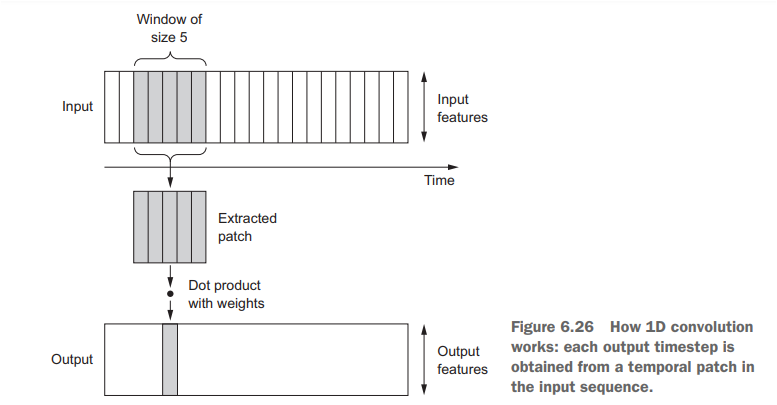

Such 1D convolution layers can recognize local patterns in a sequence. Because the
same input transformation is performed on every patch, a pattern learned at a certain
position in a sentence can later be recognized at a different position, making 1D convnets translation invariant (for temporal translations). 

For instance, a 1D convnet processing sequences of characters using convolution windows of size 5 should be able to learn words or word fragments of length 5 or less, and it should be able to recognize these words in any context in an input sequence. A character-level 1D convnet is thus
able to learn about word morphology.

### 1D pooling for sequence data

We’re already familiar with 2D pooling operations, such as 2D average pooling and
max pooling, used in convnets to spatially downsample image tensors. 

The 2D pooling operation has a 1D equivalent: extracting 1D patches (subsequences) from an input
and outputting the maximum value (max pooling) or average value (average pooling).

Just as with 2D convnets, this is used for reducing the length of 1D inputs (subsampling). 

### Implementing a 1D convnet

In **Tensorflow/Keras**, we use a 1D convnet via the `Conv1D` layer, which has an interface similar to `Conv2D`. 
* It takes as input 3D tensors with shape `(samples, time, features)` and
returns similarly shaped 3D tensors. 
* The convolution window is a 1D window on the temporal axis: `axis 1` in the input tensor.

Let’s build a simple two-layer 1D convnet and apply it to the IMDB sentiment classification task.

In [10]:
# Preparing the IMDB data

from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing import sequence

In [11]:
max_features = 10000
max_len = 500

In [12]:
print('Loading data...')

(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

print(len(x_train), 'train sequences')
print(len(x_test), 'test sequences')

Loading data...
25000 train sequences
25000 test sequences


In [13]:
print('Pad sequences (samples x time)')

x_train = sequence.pad_sequences(x_train, maxlen=max_len)
x_test = sequence.pad_sequences(x_test, maxlen=max_len)

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)

Pad sequences (samples x time)
x_train shape: (25000, 500)
x_test shape: (25000, 500)


1D convnets are structured in the same way as their 2D counterparts. They consist of a stack of `Conv1D` and `MaxPooling1D` layers, ending in either a **global pooling layer** or a **Flatten layer**, that turn the 3D outputs into 2D outputs, allowing us to add one or more Dense layers to the model for classification or regression.
 
One difference, though, is the fact that we can afford to use larger convolution
windows with 1D convnets. 
* With a 2D convolution layer, a `3 × 3` convolution window
contains `3 × 3 = 9` feature vectors; but
* With a 1D convolution layer, a convolution window of size 3 contains only 3 feature vectors. We can thus easily afford 1D convolution
windows of size `7` or `9`

In [14]:
# Training and evaluating a simple 1D convnet on the IMDB data

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Embedding(max_features, 128, input_length=max_len))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.MaxPooling1D(5))
model.add(layers.Conv1D(32, 7, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))
model.summary()

model.compile(optimizer=RMSprop(lr=1e-4),loss='binary_crossentropy',metrics=['acc'])

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 128)          1280000   
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 494, 32)           28704     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 98, 32)            0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 92, 32)            7200      
_________________________________________________________________
global_max_pooling1d_2 (Glob (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 33        
Total params: 1,315,937
Trainable params: 1,315,937
Non-trainable params: 0
____________________________________________

In [15]:
history = model.fit(x_train, y_train,epochs=10,batch_size=128,validation_split=0.2)

Epoch 1/10
157/157 [==============================] - 83s 509ms/step - loss: 0.7520 - acc: 0.5113 - val_loss: 0.6868 - val_acc: 0.5564
Epoch 2/10
157/157 [==============================] - 83s 532ms/step - loss: 0.6715 - acc: 0.6305 - val_loss: 0.6736 - val_acc: 0.5934
Epoch 3/10
157/157 [==============================] - 104s 665ms/step - loss: 0.6435 - acc: 0.7204 - val_loss: 0.6346 - val_acc: 0.7138
Epoch 4/10
157/157 [==============================] - 102s 652ms/step - loss: 0.5874 - acc: 0.7824 - val_loss: 0.5393 - val_acc: 0.7830
Epoch 5/10
157/157 [==============================] - 106s 674ms/step - loss: 0.4794 - acc: 0.8212 - val_loss: 0.4677 - val_acc: 0.8162
Epoch 6/10
157/157 [==============================] - 116s 735ms/step - loss: 0.3904 - acc: 0.8496 - val_loss: 0.4539 - val_acc: 0.8334
Epoch 7/10
157/157 [==============================] - 124s 793ms/step - loss: 0.3433 - acc: 0.8731 - val_loss: 0.4490 - val_acc: 0.8408
Epoch 8/10
157/157 [==============================

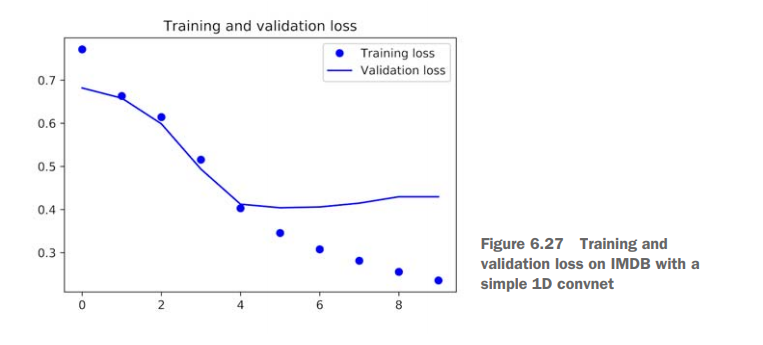

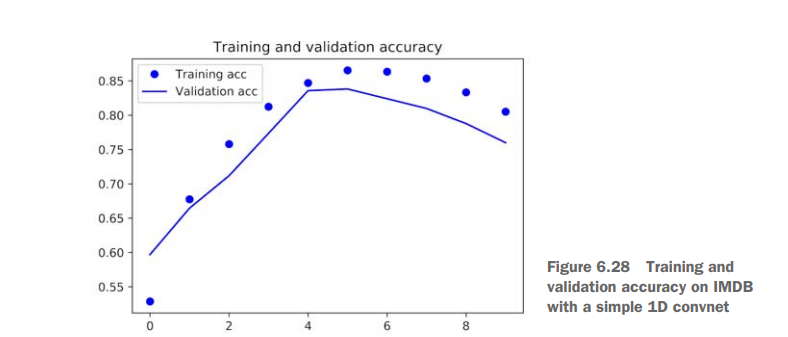

Figures above show the training and validation results. Validation accuracy is
somewhat less than that of the LSTM, but runtime is faster on both CPU and GPU (the
exact increase in speed will vary greatly depending on our exact configuration). 

At this point, we could retrain this model for the right number of epochs (`eight`) and run it
on the test set. This is a convincing demonstration that a 1D convnet can offer a fast,
cheap alternative to a recurrent network on a word-level sentiment-classification task.

### Combining CNNs and RNNs to process long sequences

Because 1D convnets process input patches independently, they aren’t sensitive to the
order of the timesteps (beyond a local scale, the size of the convolution windows),
unlike RNNs. 

Of course, to recognize longer-term patterns, we can stack many convolution layers and pooling layers, resulting in upper layers that will see long chunks of
the original inputs—but that’s still a fairly weak way to induce order sensitivity. 

One way to evidence this weakness is to try 1D convnets on the temperature-forecasting
problem, where order-sensitivity is key to producing good predictions.

In [16]:
import os

data_dir = 'jena_climate'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

In [17]:
f = open(fname)
data = f.read()
f.close()

In [18]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

In [19]:
# Parsing the data

import numpy as np

float_data = np.zeros((len(lines), len(header) - 1))

for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

In [20]:
# Normalizing the data

mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

In [21]:
# Generator yielding timeseries samples and their targets

def generator(data, lookback, delay, min_index, max_index,shuffle=False, batch_size=128, step=6):
    
    if max_index is None:
        max_index = len(data) - delay - 1
    
    i = min_index + lookback
    
    while 1:
        
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        
        for j, row in enumerate(rows):
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            targets[j] = data[rows[j] + delay][1]
        
        yield samples, targets

In [22]:
# Preparing the training, validation, and test generators

lookback = 1440
step = 6
delay = 144
batch_size = 128

In [23]:
train_gen = generator(float_data,lookback=lookback,delay=delay,min_index=0,
                      max_index=200000,shuffle=True,step=step,batch_size=batch_size)

val_gen = generator(float_data,lookback=lookback,delay=delay,min_index=200001,
                    max_index=300000,step=step,batch_size=batch_size)

test_gen = generator(float_data,lookback=lookback,delay=delay,min_index=300001,
                     max_index=None,step=step,batch_size=batch_size)

In [24]:
# How many steps to draw from val_gen in order to see the entire validation set
val_steps = (300000 - 200001 - lookback)

# How many steps to draw from test_gen in order to see the entire test set 
test_steps = (len(float_data) - 300001 - lookback)

In [25]:
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

In [26]:
model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GlobalMaxPooling1D())
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')

In [28]:
history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,
                              validation_data=val_gen,validation_steps=val_steps)

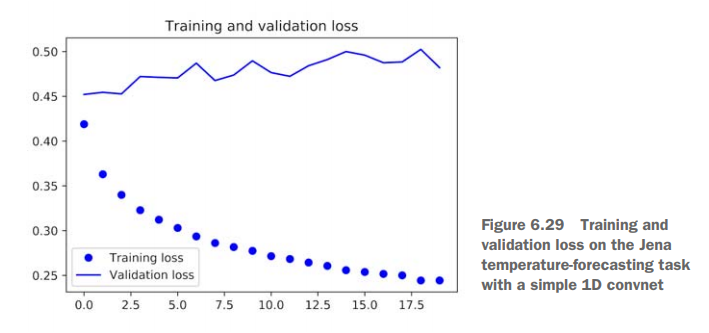

The validation MAE stays in the `0.40s`: we can’t even beat the common-sense baseline
using the small convnet. Again, this is because the convnet looks for patterns anywhere in the input timeseries and has no knowledge of the temporal position of a pattern it sees (toward the beginning, toward the end, and so on). 

Because more recent data points should be interpreted differently from older data points in the case of this specific forecasting problem, the convnet fails at producing meaningful results. This
limitation of convnets isn’t an issue with the IMDB data, because patterns of keywords
associated with a positive or negative sentiment are informative independently of
where they’re found in the input sentences.
 
One strategy to combine the speed and lightness of convnets with the order-sensitivity
of RNNs is to use a 1D convnet as a preprocessing step before an RNN.

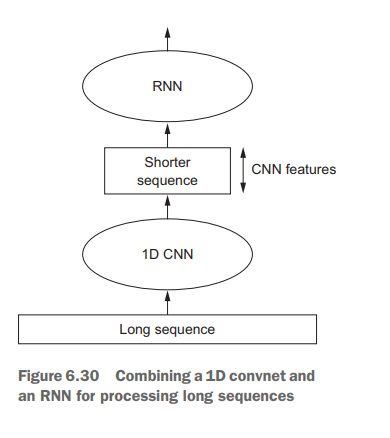

This is especially beneficial when we’re dealing with sequences that are so long they can’t
realistically be processed with RNNs, such as
sequences with thousands of steps. The convnet will turn the long input sequence into
much shorter (downsampled) sequences of higher-level features. This sequence of
extracted features then becomes the input to the RNN part of the network.

This technique isn’t seen often in
research papers and practical applications,
possibly because it isn’t well known. It’s effective and ought to be more common. Let’s try
it on the temperature-forecasting dataset.

Because this strategy allows us to manipulate much longer sequences, we can either look at data from longer ago (by increasing the lookback parameter of the data generator) or look at high-resolution timeseries (by decreasing the step parameter of the
generator). 

Here, somewhat arbitrarily, we’ll use a step that’s half as large, resulting
in a timeseries twice as long, where the temperature data is sampled at a rate of
1 point per 30 minutes. The example reuses the generator function defined earlier.

In [29]:
# Preparing higher-resolution data generators for the Jena dataset

step = 3 # Previously set to 6 (1 point per hour); Unchanged now 3 (1 point per 30 min)
lookback = 720 # unchanged
delay = 144 # unchanged

In [30]:
train_gen = generator(float_data,lookback=lookback,delay=delay,
                      min_index=0,max_index=200000,shuffle=True,step=step)

val_gen = generator(float_data,lookback=lookback,delay=delay,
                    min_index=200001,max_index=300000,step=step)

test_gen = generator(float_data,lookback=lookback,delay=delay
                     ,min_index=300001,max_index=None,step=step)

val_steps = (300000 - 200001 - lookback) // 128
test_steps = (len(float_data) - 300001 - lookback) // 128

Following is the model, starting with **two Conv1D layers** and following up with a `GRU` layer.

In [31]:
# Model combining a 1D convolutional base and a GRU layer

from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.optimizers import RMSprop

model = Sequential()
model.add(layers.Conv1D(32, 5, activation='relu',input_shape=(None, float_data.shape[-1])))
model.add(layers.MaxPooling1D(3))
model.add(layers.Conv1D(32, 5, activation='relu'))
model.add(layers.GRU(32, dropout=0.1, recurrent_dropout=0.5))
model.add(layers.Dense(1))

model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, None, 32)          2272      
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, None, 32)          0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, None, 32)          5152      
_________________________________________________________________
gru (GRU)                    (None, 32)                6336      
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 33        
Total params: 13,793
Trainable params: 13,793
Non-trainable params: 0
_________________________________________________________________


In [32]:
model.compile(optimizer=RMSprop(), loss='mae')

history = model.fit_generator(train_gen,steps_per_epoch=500,epochs=20,
                              validation_data=val_gen,validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 110s 206ms/step - loss: 0.3669 - val_loss: 0.3104
Epoch 2/20
500/500 [==============================] - 98s 197ms/step - loss: 0.3007 - val_loss: 0.3004
Epoch 3/20
500/500 [==============================] - 129s 258ms/step - loss: 0.2853 - val_loss: 0.2886
Epoch 4/20
500/500 [==============================] - 139s 278ms/step - loss: 0.2737 - val_loss: 0.2810
Epoch 5/20
500/500 [==============================] - 137s 273ms/step - loss: 0.2666 - val_loss: 0.2816
Epoch 6/20
500/500 [==============================] - 137s 275ms/step - loss: 0.2610 - val_loss: 0.2817
Epoch 7/20
500/500 [==============================] - 161s 322ms/step - loss: 0.2508 - val_loss: 0.2897
Epoch 8/20
500/500 [==============================] - 143s 286ms/step - loss: 0.2488 - val_loss: 0.2864
Epoch 9/20
500/500 [==============================] - 158s 317ms/step - loss: 0.2421 - val_loss: 0.2983
Epoch 10/20
500/500 [==============================] - 143s 287ms

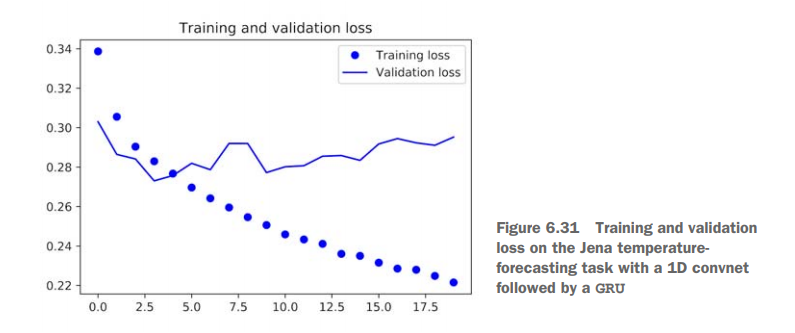

Judging from the validation loss, this setup isn’t as good as the regularized GRU alone,
but it’s significantly faster. It looks at twice as much data, which in this case doesn’t
appear to be hugely helpful but may be important for other datasets. 

# Conclusion

Here’s what should we take away:

* In the same way that 2D convnets perform well for processing visual patterns in
2D space, 1D convnets perform well for processing temporal patterns. They
offer a faster alternative to RNNs on some problems, in particular natural language processing tasks.
* Typically, 1D convnets are structured much like their 2D equivalents from the
world of computer vision: they consist of stacks of Conv1D layers and MaxPooling1D layers, ending in a global pooling operation or flattening operation.
* Because RNNs are extremely expensive for processing very long sequences, but
1D convnets are cheap, it can be a good idea to use a 1D convnet as a preprocessing step before an RNN, shortening the sequence and extracting useful representations for the RNN to process. 

### Chapter 6 summary

* In this chapter, we learned the following techniques, which are widely
applicable to any dataset of sequence data, from text to timeseries:
    * How to tokenize text
    * What word embeddings are, and how to use them
    * What recurrent networks are, and how to use them
    * How to stack RNN layers and use bidirectional RNNs to build more-powerful sequence-processing models
    * How to use 1D convnets for sequence processing
    * How to combine 1D convnets and RNNs to process long sequences
* We can use RNNs for timeseries regression **(predicting the future)**, timeseries classification, anomaly detection in timeseries, and sequence labeling (such as identifying names or dates in sentences).
* Similarly, we can use 1D convnets for machine translation (sequence-to-sequence convolutional models, like `SliceNet`), document classification,and spelling correction.
* If global order matters in our sequence data, then it’s preferable to use a recurrent network to process it. This is typically the case for timeseries,
where the recent past is likely to be more informative than the distant past.
* If global ordering isn’t fundamentally meaningful, then 1D convnets will turn
out to work at least as well and are cheaper. This is often the case for text
data, where a keyword found at the beginning of a sentence is just as
meaningful as a keyword found at the end.